# Intro to Embeddings

In this notebook, we learn on how to build good embeddings for words, through sequential data (sentences) - in other words, "Word2Vec". We are not so much interested in the NLP part of it, but in a more general point: if we pick a good prediction task (such as guessing the next word in a sentence), we will obtain "good embeddings", that is embeddings that are good representations of the underlying concepts.

You are encouraged to play around with the code and modify / re-built parts of it as you fit: there is NO substitute for "tinkering with code" to understand how all the concepts fit together (corollary: all this code is written for pedagogical purposes, so some functions are re-used from previous lectures to provide a self-sufficient script).

In [1]:
# some global imports
import json
import glob
import os
import pandas as pd
from collections import Counter
from random import sample
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

## Data loading

In [3]:
# make sure you have the datasets library installed
# see: https://github.com/huggingface/datasets

# !pip install datasets

In [4]:
import string

# some utils function
def get_finance_sentiment_dataset(split: str='sentences_allagree'):
    # load financial dataset from HF
    from datasets import load_dataset
    # https://huggingface.co/datasets/financial_phrasebank
    # by default, load just sentences for which all annotators agree
    dataset = load_dataset("financial_phrasebank", split)
    
    return dataset['train']


def get_finance_sentences():
    dataset = get_finance_sentiment_dataset()
    cleaned_dataset = [[pre_process_sentence(_['sentence']), _['label']] for _ in dataset]
    # debug 
    print("{} cleaned sentences from finance dataset\n".format(len(cleaned_dataset)))
    
    return cleaned_dataset


def pre_process_sentence(sentence: str):
    # this choices are VERY important. Here, we take a simplified 
    # view, remove the punctuations and just lower case everything
    lower_sentence = sentence.lower()
    exclude = set(string.punctuation)
    return ''.join(ch for ch in lower_sentence if ch not in exclude)

In [5]:
finance_dataset = get_finance_sentences()
# print out the first items in the dataset, to check the format
finance_dataset[:2]

Found cached dataset financial_phrasebank (/Users/jacopotagliabue/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

2264 cleaned sentences from finance dataset



[['according to gran  the company has no plans to move all production to russia  although that is where the company is growing ',
  1],
 ['for the last quarter of 2010  componenta s net sales doubled to eur131m from eur76m for the same period a year earlier  while it moved to a zero pretax profit from a pretax loss of eur7m ',
  2]]

In [6]:
# get sentences without label for vectorizer part
finance_dataset_sentences = [_[0] for _ in finance_dataset]

## From words to embeddings with Word2Vec

Let us use word2vec to get vectors for words first, and document after. We will use a fantastic Python library, gensim: https://radimrehurek.com/gensim/models/word2vec.html

In [7]:
#!pip install gensim==4.2

In [8]:
import gensim

In [9]:
def train_word2vec_model(
    sentences: list,
    min_count: int = 2,
    vector_size: int = 48,
    window: int = 2,
    epochs: int = 20
):
    """
    Sentences is a list of lists, where each list is composed by tokens in a sentence: e.g.
    
    [
        ['the', 'cat', 'is', 'on' ...],
        ['i', 'live', 'in', 'nyc', ...],
        ....
    ]
    
    """
    model =  gensim.models.Word2Vec(sentences=sentences,
                                    min_count=min_count,
                                    vector_size=vector_size,
                                    window=window,
                                    epochs=epochs)
    
    # this is how many words we will have in the space
    print("# words in the space: {}".format(len(model.wv.index_to_key)))

    # we return the space in a format that will allow us to do nice things afterwards ;-)    
    return model.wv

In [10]:
# let's use nltk tokenizer to break up sentences and build a word2vec model
# https://www.nltk.org/api/nltk.tokenize.html
from nltk.tokenize import word_tokenize

print(finance_dataset_sentences[0], '\n\n', word_tokenize(finance_dataset_sentences[0]))

according to gran  the company has no plans to move all production to russia  although that is where the company is growing  

 ['according', 'to', 'gran', 'the', 'company', 'has', 'no', 'plans', 'to', 'move', 'all', 'production', 'to', 'russia', 'although', 'that', 'is', 'where', 'the', 'company', 'is', 'growing']


In [11]:
tokenized_sentences = [word_tokenize(_) for _ in finance_dataset_sentences]
# debug 
tokenized_sentences[0][:5]

['according', 'to', 'gran', 'the', 'company']

In [12]:
# build a counter to get a sense of the lexicon
word_counter = Counter([item for sent in tokenized_sentences for item in sent])
word_counter.most_common(10)

[('the', 2730),
 ('of', 1525),
 ('in', 1384),
 ('and', 1166),
 ('to', 1081),
 ('eur', 756),
 ('a', 725),
 ('for', 541),
 ('from', 517),
 ('s', 456)]

In [13]:
w2v_model = train_word2vec_model(tokenized_sentences)

# words in the space: 2920


In [14]:
# each word now has one vector corresponding to it ->
w2v_model['the']

array([ 1.0666009 , -0.09351671,  0.5181832 ,  0.93801737, -0.16310038,
       -0.23601803,  0.653662  ,  0.20301197,  0.08346839, -0.4392337 ,
        0.6271822 ,  0.7403718 ,  0.1560341 , -0.5054599 , -0.58326554,
       -0.28301153,  1.1567134 , -0.17982325, -0.7669375 , -0.5771703 ,
        0.9905063 ,  0.03453461,  1.0675987 ,  0.21683699,  0.19390678,
       -0.7610366 , -0.64601135, -0.3805992 ,  0.3287149 , -0.24299656,
       -0.87390447,  0.3160652 ,  0.3268023 , -0.21296579, -0.14288795,
        0.7765016 ,  0.5196831 ,  0.4102347 ,  0.38487014,  0.00495257,
       -0.65852934,  0.40230864, -0.744167  , -0.88486105,  0.49332303,
        0.09278548,  0.6277791 ,  1.251982  ], dtype=float32)

Now that we have a vector space, let's find words similar to a given term...

In [15]:
for w in ['company', 'profit']:
    print('\n======>{}\n'.format(w), w2v_model.similar_by_word(w, topn=3))


======>company
 [('group', 0.9086247086524963), ('media', 0.8629387617111206), ('bank', 0.8550969958305359)]

======>profit
 [('loss', 0.9637013673782349), ('income', 0.9343879222869873), ('margin', 0.9224969744682312)]


To get a sense of what the vectors look like, we print them out in 2D using TSNE (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html):

In [16]:
def plot_scatter_by_category_with_lookup(title, 
                                         words, 
                                         word_to_target_cat,
                                         results):
    """
    Just a plotting routine
    """
    
    groups = {}
    for word, target_cat in word_to_target_cat.items():
        if word not in words:
            continue

        word_idx = words.index(word)
        x = results[word_idx][0]
        y = results[word_idx][1]
        if target_cat in groups:
            groups[target_cat]['x'].append(x)
            groups[target_cat]['y'].append(y)
        else:
            groups[target_cat] = {
                'x': [x], 'y': [y]
                }
    
    fig, ax = plt.subplots(figsize=(10, 10))
    for group, data in groups.items():
        ax.scatter(data['x'], data['y'], 
                   alpha=0.1 if group == 0 else 0.8, 
                   edgecolors='none', 
                   s=25, 
                   marker='o',
                   label=group)

    plt.title(title)
    plt.legend(loc=2)
    plt.show()
    
    return

In [17]:
def tsne_analysis(embeddings, perplexity=25, n_iter=1000):
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=n_iter)
    return tsne.fit_transform(embeddings)

In [18]:
# map words to known categories of interest

# 0 is the generic category
words = w2v_model.index_to_key
print(len(words))
words_to_category = {w: 0 for w in words}
# manually pick some words to display
for w in ['company', 'profit', 'investment', 'loss', 'margin', 'group']:
    words_to_category[w] = 1
for w in ['with', 'of', 'from', 'by', 'as']:
    words_to_category[w] = 2

2920


In [19]:
embeddings = [w2v_model[w] for w in words]
tsne_results = tsne_analysis(embeddings)
assert len(tsne_results) == len(words)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 2920 samples in 0.005s...
[t-SNE] Computed neighbors for 2920 samples in 0.312s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2920
[t-SNE] Computed conditional probabilities for sample 2000 / 2920
[t-SNE] Computed conditional probabilities for sample 2920 / 2920
[t-SNE] Mean sigma: 0.074680
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.342331
[t-SNE] KL divergence after 1000 iterations: 1.392562


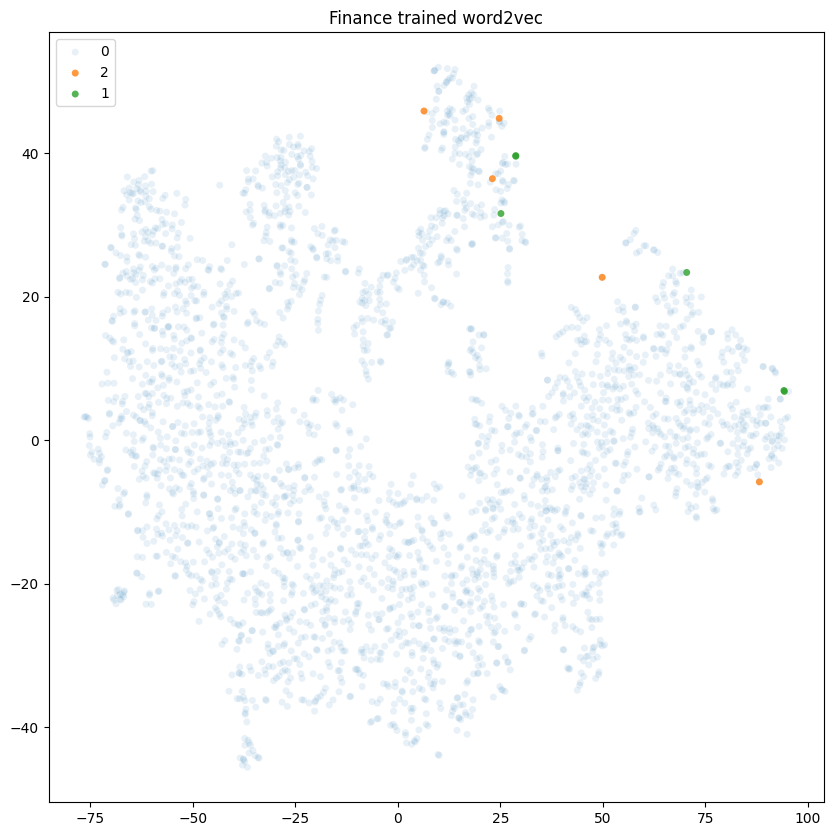

In [20]:
plot_scatter_by_category_with_lookup('Finance trained word2vec', words, words_to_category, tsne_results)

_Why the quality is not ideal?_

Our dataset is very small, and word2vec works much better when large corpora are used. What if we trained the vectors on a much bigger dataset, say, Wikipedia?

We don't have to, as we can donwload embeddings for words as gently pretrained by other researchers - let's do the same qualitative checks, but on Wikipedia embeddings!

In [21]:
import gensim.downloader as api

In [22]:
# glove-wiki-gigaword-50 (400000 records): Pre-trained vectors based on Wikipedia
pre_trained_model = api.load("glove-wiki-gigaword-50")
# test it out
for w in ['company', 'profit']:
    print('\n======>{}\n'.format(w), pre_trained_model.similar_by_word(w, topn=3))


======>company
 [('firm', 0.888496994972229), ('subsidiary', 0.8764045238494873), ('companies', 0.8662537336349487)]

======>profit
 [('earnings', 0.9254103899002075), ('profits', 0.9171135425567627), ('shares', 0.8507129549980164)]


In [23]:
words =[w for w in w2v_model.index_to_key if w in pre_trained_model]
print(len(words))
pre_trained_vectors = [pre_trained_model[w] for w in words]
pre_trained_tsne_results = tsne_analysis(pre_trained_vectors)

2672
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 2672 samples in 0.004s...
[t-SNE] Computed neighbors for 2672 samples in 0.407s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2672
[t-SNE] Computed conditional probabilities for sample 2000 / 2672
[t-SNE] Computed conditional probabilities for sample 2672 / 2672
[t-SNE] Mean sigma: 1.285566
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.791222
[t-SNE] KL divergence after 1000 iterations: 1.765099


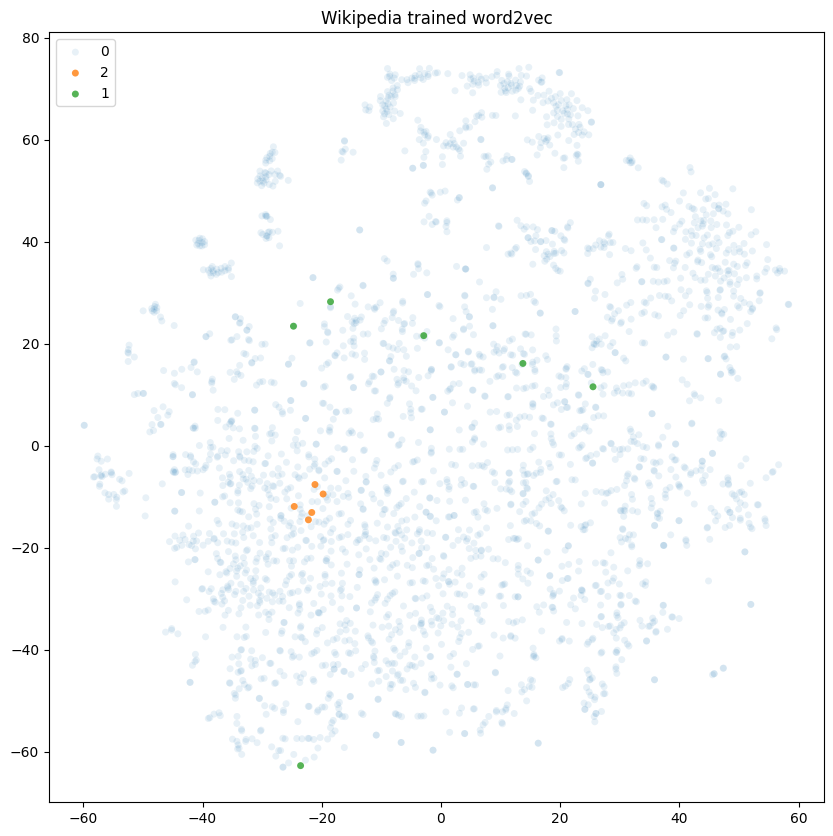

In [24]:
plot_scatter_by_category_with_lookup('Wikipedia trained word2vec', 
                                     words, 
                                     words_to_category, 
                                     pre_trained_tsne_results)

_Let's try some other categories on the full Wikipedia corpus!_

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1040 samples in 0.002s...
[t-SNE] Computed neighbors for 1040 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1040
[t-SNE] Computed conditional probabilities for sample 1040 / 1040
[t-SNE] Mean sigma: 1.310061
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.749840
[t-SNE] KL divergence after 1000 iterations: 2.081693


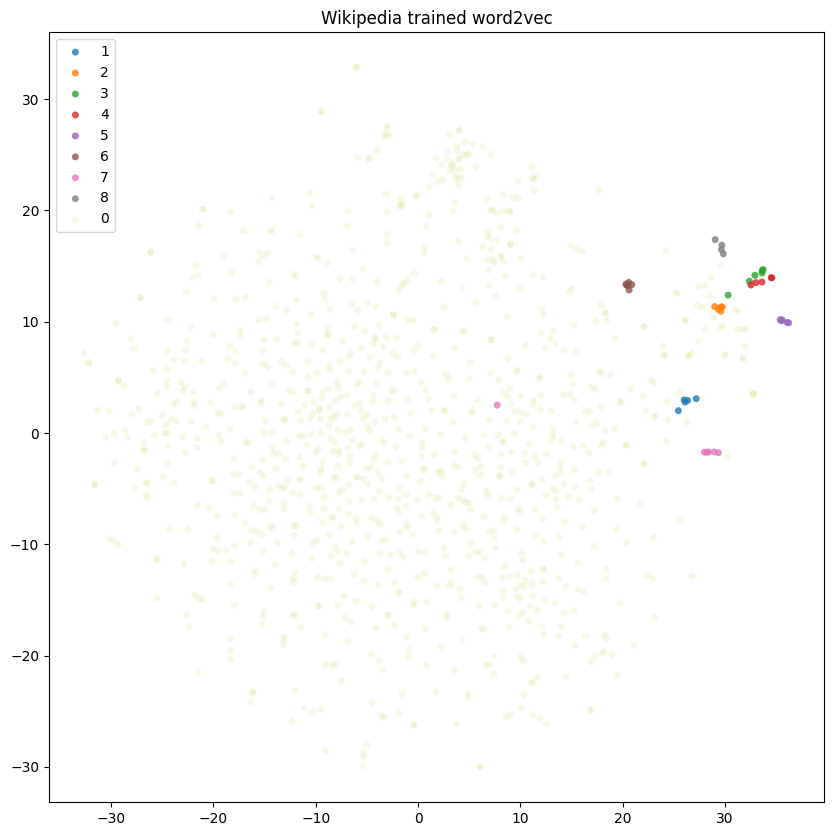

In [25]:
# build a new mapping and manually pick some words to display
wiki_words_to_category = {}
for w in ['dog', 'cat', 'bunny', 'horse', 'snake']:
    wiki_words_to_category[w] = 1
for w in ['with', 'of', 'from', 'by', 'as']:
    wiki_words_to_category[w] = 2
for w in ['italy', 'france', 'spain', 'germany', 'portugal', 'china']:
    wiki_words_to_category[w] = 3
for w in ['rome', 'berlin', 'paris', 'milan', 'madrid']:
    wiki_words_to_category[w] = 4
for w in ['tennis', 'soccer', 'basketball', 'volleyball', 'football']:
    wiki_words_to_category[w] = 5
for w in ['dress', 'skirt', 'pants', 'trousers', 'shirt', 'denim']:
    wiki_words_to_category[w] = 6
for w in ['pasta', 'pizza', 'dumplings', 'ramen', 'sushi', 'burger']:
    wiki_words_to_category[w] = 7
for w in ['dollar', 'yen', 'euro', 'rupee']:
    wiki_words_to_category[w] = 8
    
# limit to 10000 words to speed up TSNE    
wiki_words = list(set(sample(pre_trained_model.index_to_key, 1000) + list(wiki_words_to_category.keys()))) 
for w in wiki_words:
    if w not in wiki_words_to_category:
        wiki_words_to_category[w] = 0

# display
wiki_pre_trained_vectors = [pre_trained_model[w] for w in wiki_words]
wiki_pre_trained_tsne_results = tsne_analysis(wiki_pre_trained_vectors)
plot_scatter_by_category_with_lookup('Wikipedia trained word2vec', 
                                     wiki_words, 
                                     wiki_words_to_category, 
                                     wiki_pre_trained_tsne_results)

### Bonus: word2vec for analogies

A famous property of word2vec is the ability to capture analogical relations through the embedding space, such as for example:

man : king = woman : ?

We re-use a pre-trained model, trained on wikipedia, to show how analogies are encoded in the latent space.

In [26]:
# get a model trained on twitter: https://radimrehurek.com/gensim/auto_examples/howtos/run_downloader_api.html
pre_trained_model = api.load("glove-twitter-50")

_Note that most_similar is performing here a KNN on the vector space using cosine similarity_ 

In [27]:
def analogy(model, worda, wordb, wordc):
    result = model.most_similar(negative=[worda], 
                                positive=[wordb, wordc])
    return result[0][0]

In [28]:
print(analogy(pre_trained_model, 'king', 'man', 'queen'))

girl


In [29]:
countries = ['australia', 'canada', 'germany', 'ireland', 'italy']
foods = [analogy(pre_trained_model, 'us', 'hamburger', country) for country in countries]

In [30]:
for c, f in zip(countries, foods):
    print(c, f)

australia hopman
canada cheeseburger
germany lasagne
ireland lasagne
italy bolognese
